In [95]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import re
import nltk
from bs4 import BeautifulSoup
from nltk.tag import pos_tag
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [5]:
data = pd.read_csv('D:/Applied AI/Projects/IMDB.csv')

In [6]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
data['sentiment'] = data['sentiment'].map(
                   {'positive':1 ,'negative':0})

In [8]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [9]:
#printing the shape of the dataset
print('-----Shape of the dataset-----')
data.shape

-----Shape of the dataset-----


(50000, 2)

In [10]:
#printing the distribution of the dataset
data['sentiment'].value_counts()

0    25000
1    25000
Name: sentiment, dtype: int64

In [11]:
#Nan/Null Value and Duplicate Checks
print('we have {} Nan/null values in the dataset'.format(data.isnull().values.sum()))
print('Number of duplicates in dataset {}'.format(sum(data['review'].duplicated())))

we have 0 Nan/null values in the dataset
Number of duplicates in dataset 418


In [12]:
#removing duplicates
print('==== Removing Duplicates=====')
data = data.drop_duplicates(subset={'review'},keep='first', inplace=False)
data.shape

==== Removing Duplicates=====


(49582, 2)

In [13]:
# printing some random reviews
print('------PRINTING SOME RANDOM REVIEWS-----')
print('\n')
sent_0 = data['review'].values[0]
print(sent_0)

print("="*200)

sent_1000 = data['review'].values[1000]
print(sent_1000)
print("="*200)

sent_1500 = data['review'].values[1500]
print(sent_1500)
print("="*200)

sent_4900 = data['review'].values[4900]
print(sent_4900)
print("="*200)

------PRINTING SOME RANDOM REVIEWS-----


One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the

# Removing all urls from the data

In [14]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)



One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

# Removing all tags from the data

In [15]:
#Removing all tags from the reviews
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*200)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*200)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*200)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wou

# Decontracting the words

In [16]:
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# Removing words with numbers from data

In [17]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

One of the other reviewers has mentioned that after watching just  Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact

# Removing special character from data

In [18]:
#remove special character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Oh dear god This was horrible There is bad then there was this This movie makes no sense at all It runs all over the map and isn t clear about what its saying at all The music seemed like it was trying to be like Batman The fact that Edison isn t a real city takes away Since I live in Vancouver watching this movie and recognizing all these places made it unbearable Why didn t they make it a real city The only writing that was decent was Tilman in which John Heard did a fantastic job He was the only actor who played his role realistically and not over the top and campy It was actually a shame to see John Heard play such a great bad guy with a lot of screen time and the movie be a washout Too bad Hopefully someone important will see it and at least give John Heard credit where credit is due and hire him as lead bad guy again which is where he should be on the A List 


In [19]:
nltk.download('stopwords')
eng_stopwords = set(stopwords.words('english'))
def cleaning(data):
    preprocessed_reviews = []
    for sentance in tqdm(data['review'].values):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in eng_stopwords) #removing stopwords and converting into lowercase letters
        preprocessed_reviews.append(sentance.strip())
    data['review']=preprocessed_reviews
    return data


[nltk_data] Downloading package stopwords to C:\Users\Vaddiraju Sri
[nltk_data]     Harsha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
data_after_cleaning = cleaning(data)
data_after_cleaning.to_csv('after_cleaning.csv')

100%|██████████████████████████████████████████████████████████████████████████| 49582/49582 [00:21<00:00, 2340.91it/s]


In [25]:
#data after cleaning
print(data_after_cleaning['review'].values[100])

short film inspired soon full length feature spatula madness hilarious piece contends similar cartoons yielding multiple writers short film stars edward spatula fired job joins fight evil spoons premise allows funny content near beginning barely present remainder feature film running time absorbed odd ball comedy small musical number unfortunately much else lies plot set really time show surely follows plot better many high budget hollywood films film worth watching least times take expect deep story


# Stemming

In [29]:
def stemmer(data):
    
    review_clean_ps = []
    ps = PorterStemmer()
    for sentance in tqdm(data['review'].values):
        
        ps_stems = []
        
        for w in sentance.split():
            if w == 'oed':
                continue
                ps_stems.append(ps.stem(w))
                
                review_clean_ps.append(' '.join(ps_stems))
                
                data['review']=review_clean_ps
    return data
                
    

In [30]:
data_stemmer=stemmer(data_after_cleaning)

100%|████████████████████████████████████████████████████████████████████████| 49582/49582 [00:00<00:00, 104382.45it/s]


In [48]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

# Lemmatization

In [63]:

def lemmatizer(data):
    review_clean_wnl = []
    wnl = WordNetLemmatizer()
    for sentance in tqdm(data['review'].values):
        wnl_stems = []
        token_tag = pos_tag(sentance.split())
        for pair in token_tag:
            res = wnl.lemmatize(pair[0],pos=get_wordnet_pos(pair[1]))
            wnl_stems.append(res)
            review_clean_wnl.append(' '.join(wnl_stems))
            data['review']=review_clean_wnl
    return data
                

  0%|                                                                                        | 0/49582 [00:00<?, ?it/s]


ValueError: Length of values (1) does not match length of index (49582)

In [72]:
data_model=pd.read_csv("D:/Applied AI/Projects/after_cleaning.csv")

In [73]:
data_model.head()

,Unnamed: 0,review,sentiment
0,0,one reviewers mentioned watching oz episode ho...,1
1,1,wonderful little production filming technique ...,1
2,2,thought wonderful way spend time hot summer we...,1
3,3,basically family little boy jake thinks zombie...,0
4,4,petter mattei love time money visually stunnin...,1


In [74]:
print('-----SHAPE OF THE DATASET')
print(data_model.shape)

-----SHAPE OF THE DATASET
(49582, 3)


In [75]:
print('---Distribution of dataset---')
print(data_model['sentiment'].value_counts())

---Distribution of dataset---
1    24884
0    24698
Name: sentiment, dtype: int64


# Nan/Null Value and Duplicate Checks

In [79]:
print('we have {} Nan/null values'.format(data_model.isnull().values.sum()))
print('no.of duplicates identified {}'.format(sum(data_model['review'].duplicated())))


we have 0 Nan/null values
no.of duplicates identified 7


In [81]:
#Dropping the duplicates
print('-----REMOVING DUPLICATE ROWS------')
data_model = data_model.drop_duplicates(subset={'review'},keep='first',inplace=False)
data_model.shape

-----REMOVING DUPLICATE ROWS------


(49575, 3)

In [83]:
X= data_model['review']
Y= data_model['sentiment']
print(X.shape)
print(Y.shape)


(49575,)
(49575,)


In [85]:
#Splitting into train and test data
X_train, X_test,y_train,y_test = train_test_split(X,Y,test_size = 0.25,random_state = 42)
print('Train data', X_train.shape)
print('Test Data',X_test.shape)

Train data (37181,)
Test Data (12394,)


For text featurizations we can use many strategies, but the most common strategies are 1) Bag of words 2) TF-IDF

# Bag of words

In [88]:
#bag of words
vectorizer_bow = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_bow.fit(X_train.values)  #fitting
x_train_bow= vectorizer_bow.transform(X_train.values) 
x_test_bow= vectorizer_bow.transform(X_test.values)

print("After vectorizations")
print(x_train_bow.shape, y_train.shape)
print(x_test_bow.shape, y_test.shape)
print("="*40)


After vectorizations
(37181, 5000) (37181,)
(12394, 5000) (12394,)


# TF-IDF Vectorizer

In [89]:
#tfidf
tfidfvectorizer = TfidfVectorizer(min_df=10,max_features=5000)
text_tfidf = tfidfvectorizer.fit(X_train.values) #fitting

X_train_tfidf =tfidfvectorizer.transform(X_train.values) 
X_test_tfidf =tfidfvectorizer.transform(X_test.values)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*40)

After vectorizations
(37181, 5000) (37181,)
(12394, 5000) (12394,)


# Modelling

In [90]:
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}
logreg= LogisticRegression()
logreg_cv = GridSearchCV(logreg,param_grid,cv=5)#Hyper parameter tuning
logreg_cv.fit(X_train_tfidf,y_train)
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 3.727593720314938}
Best score is 0.8840267101461132


In [92]:
lr= LogisticRegression(C= 3.727593720314938)
lr.fit(X_train_tfidf, y_train)

LogisticRegression(C=3.727593720314938)

In [93]:
print("Accuracy: ",(accuracy_score(y_test,lr.predict(X_test_tfidf))))

Accuracy:  0.8871228013554946


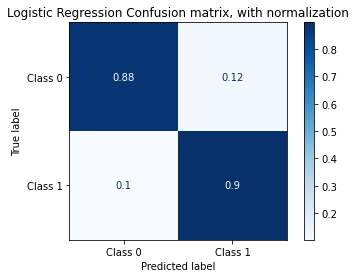

In [96]:
disp = metrics.plot_confusion_matrix(lr,X_test_tfidf, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Logistic Regression Confusion matrix, with normalization');

# Support vector machine

In [97]:
param_grid = {'C': [0.1, 1, .01 ], 
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf']}     # hyper parameter tuning
  
svm = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,cv=2)
  
svm.fit(X_train_tfidf, y_train)

print(svm.best_params_)
print(svm.best_estimator_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2] END .....................C=0.1, gamma=1, kernel=rbf; total time= 6.3min
[CV 2/2] END .....................C=0.1, gamma=1, kernel=rbf; total time= 6.5min
[CV 1/2] END ...................C=0.1, gamma=0.1, kernel=rbf; total time= 7.2min
[CV 2/2] END ...................C=0.1, gamma=0.1, kernel=rbf; total time= 7.2min
[CV 1/2] END ..................C=0.1, gamma=0.01, kernel=rbf; total time= 7.6min
[CV 2/2] END ..................C=0.1, gamma=0.01, kernel=rbf; total time= 7.7min
[CV 1/2] END .......................C=1, gamma=1, kernel=rbf; total time= 9.0min
[CV 2/2] END .......................C=1, gamma=1, kernel=rbf; total time=10.9min
[CV 1/2] END .....................C=1, gamma=0.1, kernel=rbf; total time= 4.8min
[CV 2/2] END .....................C=1, gamma=0.1, kernel=rbf; total time= 4.3min
[CV 1/2] END ....................C=1, gamma=0.01, kernel=rbf; total time= 7.0min
[CV 2/2] END ....................C=1, gamma=0.01,

In [98]:
svm=SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
svm.fit(X_train_tfidf, y_train)

SVC(C=1, gamma=1)

In [99]:
print("Accuracy: ",(accuracy_score(y_test,svm.predict(X_test_tfidf))))

Accuracy:  0.8913183798612232


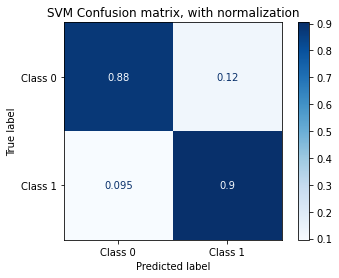

In [100]:
disp = metrics.plot_confusion_matrix(svm,X_test_tfidf, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('SVM Confusion matrix, with normalization');